# Allocating $10^{24}$ FLOPs to a single LLM

This notebook guides you through **estimating the scaling law for LLMs** (with `vocab_size=32000`) using a subset of Chinchilla training runs (filter: $10^{18} < C \wedge N < D$).

We fit the parametric loss predictor and then explore:

- The estimately optimal allocation of $10^{24}$ FLOPs.
- The transition of model-parameter ratio
- The trajectory of minimum loss possible for a given compute
- How the "20 tokens per parameter" heuristic compares

In [1]:
import numpy as np
from chinchilla import Chinchilla
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="ticks")

Define the parameter grid & fit

[09:40:43] WARNING  You did not specify `model_search_config`. In order to find a model configuration,  ]8;id=107674;file:///workspaces/chinchilla/chinchilla/core.py\core.py]8;;\:]8;id=580676;file:///workspaces/chinchilla/chinchilla/core.py#123\123]8;;\
                    You will need to either:                                                                       
                    1.  Assign `model_search_config` attribute before calling `seed` method.                       
                    2.  Find the model configuration closest to `N` yourself, and optionally call                  
                    `cc.adjust_D_to_N(N)` when scaling.                                                            

           INFO     Mounting a directory: ./                                                            ]8;id=956490;file:///workspaces/chinchilla/chinchilla/core.py\core.py]8;;\:]8;id=668152;file:///workspaces/chinchilla/chinchilla/core.py#154\154]8;;\

[09:40:43] INFO     Chinchilla instance created successfully.                                           ]8;id=58557;file:///workspaces/chinchilla/chinchilla/core.py\core.py]8;;\:]8;id=597537;file:///workspaces/chinchilla/chinchilla/core.py#159\159]8;;\

[09:43:51] INFO     Goodness-of-fit to Exp(λ=57.63): KS=np.float64(0.2),                          ]8;id=481986;file:///workspaces/chinchilla/chinchilla/visualizer.py\visualizer.py]8;;\:]8;id=209600;file:///workspaces/chinchilla/chinchilla/visualizer.py#214\214]8;;\
                    p=np.float64(0.8088043692810752)                                                               

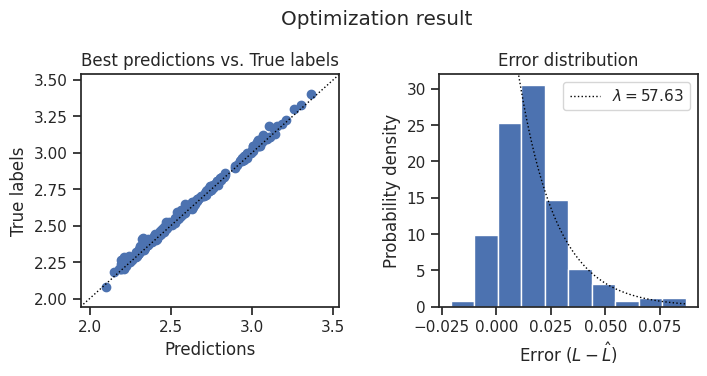

           INFO     Loss predictor:                                                                     ]8;id=977244;file:///workspaces/chinchilla/chinchilla/core.py\core.py]8;;\:]8;id=467329;file:///workspaces/chinchilla/chinchilla/core.py#371\371]8;;\
                                                                                                                   
                      L(N, D) = 1.700 + 184.7 / (N ^ 0.2890) + 1633. / (D ^ 0.3558)                                
                                                                                                                   

{'E': 1.7002408325507796,
 'A': 184.69151738172795,
 'B': 1633.4786640754548,
 'alpha': 0.2890076484429228,
 'beta': 0.3557940660048966}

In [2]:
num_slices = 5
cc = Chinchilla(
    "./",
    param_grid=dict(
        E=np.linspace(1.4, 2.0, num_slices),
        a=np.linspace(1, 10, num_slices),
        b=np.linspace(1, 10, num_slices),
        alpha=np.linspace(0.1, 0.7, num_slices),
        beta=np.linspace(0.1, 0.7, num_slices),
    ),
)
cc.fit()
cc.params

Allocate $10^{24}$ FLOPs

In [3]:
# Assume 1e24 FLOPs model
C = 1e24
(N, D) = cc.allocate_compute(C)

print(f"{C:.2g} FLOPs -> {N / 1e9:.1f}B parameters & {D / 1e12:.1f}T samples")

1e+24 FLOPs -> 160.5B parameters & 1.0T samples


Apparently, if we ever get to have $10^{24}$ FLOPs of compute, the optimal allocation would be to train a **160B parameters model on 1T tokens**.

Yuu can also call the same method using an array. In the example below we see the trajectory of estimatedly minimum loss possible over a horizon of compute FLOPs. 

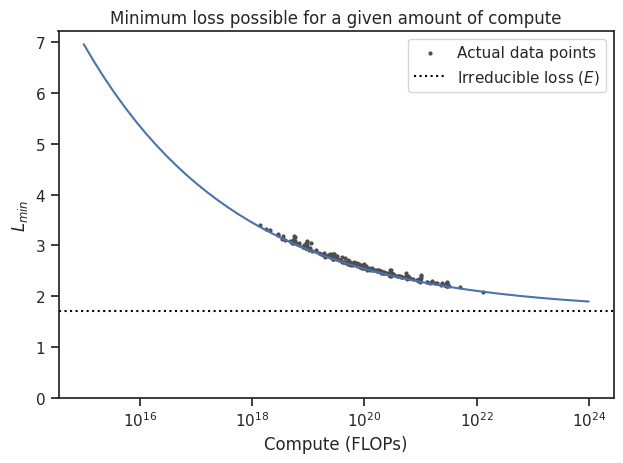

In [4]:
C = np.logspace(15, 24)  # base: 10
N, D = cc.allocate_compute(C)
L_est = cc.L(N, D)


plt.semilogx(C, L_est)
plt.scatter(cc.database.df.C, cc.database.df.loss, label="Actual data points", c=".3", s=4)
plt.axhline(cc.params["E"], ls=":", c=".0", label=r"Irreducible loss ($E$)")
plt.ylim(0, None)
plt.title("Minimum loss possible for a given amount of compute")
plt.xlabel("Compute (FLOPs)")
plt.ylabel(r"$L_{min}$")
plt.legend()
plt.tight_layout()
plt.show()

Now, let's also see how the widely used "**20 tokens per parameter**" heuristic works. First we'll see the trajectory of the optimal number of tokens per parameter as a function of compute.

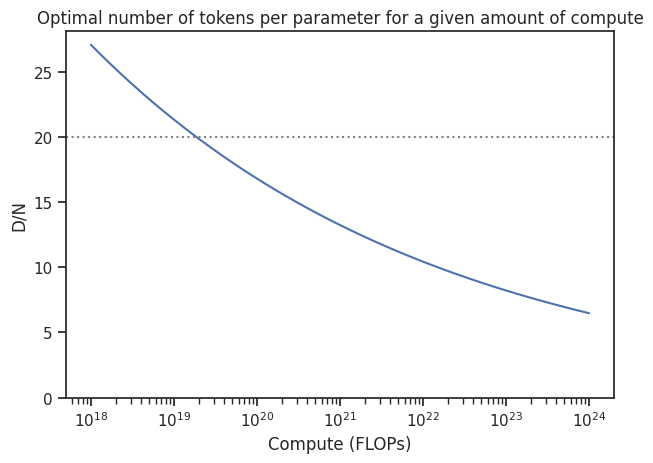

In [5]:
C = np.logspace(18, 24)  # base: 10
N, D = cc.allocate_compute(C)
tokens_per_parameter = D / N
plt.semilogx(C, tokens_per_parameter)
plt.axhline(20, ls=":", c=".5")
plt.title("Optimal number of tokens per parameter for a given amount of compute")
plt.xlabel("Compute (FLOPs)")
plt.ylabel("D/N")
plt.ylim(0, None)
plt.tight_layout()
plt.show()

Feels quite different, doesn't it? Now, let's see the expected loss you'd get with this heuristic.

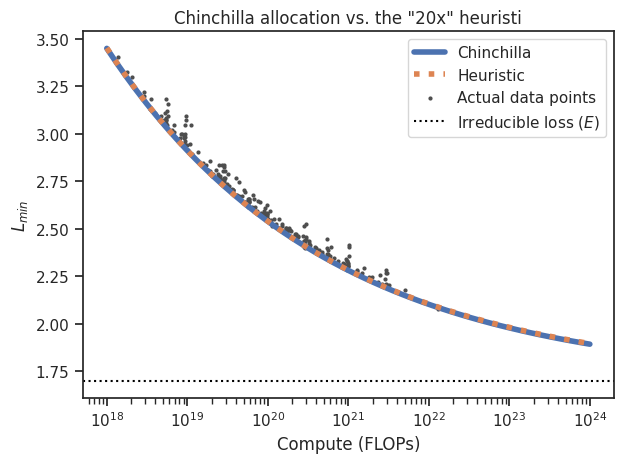

In [6]:
N, D = cc.allocate_compute(C)
L_chinchilla = cc.L(N, D)
plt.semilogx(C, L_chinchilla, label="Chinchilla", lw=4)

N = (C / (6 * 20)) ** 0.5
D = 20 * N
assert np.isclose(C, (6 * N * D)).all()
L_heuristic = cc.L(N, D)
plt.semilogx(C, L_heuristic, label="Heuristic", ls=":", lw=4)


plt.scatter(cc.database.df.C, cc.database.df.loss, label="Actual data points", c=".3", s=4)
plt.axhline(cc.params["E"], ls=":", c=".0", label=r"Irreducible loss ($E$)")
plt.title('Chinchilla allocation vs. the "20x" heuristi')
plt.xlabel("Compute (FLOPs)")
plt.ylabel(r"$L_{min}$")
plt.legend()
plt.tight_layout()
plt.show()

Well, in fact, the heuristic comes so close to the esttimated optimal that the difference could be considered negligibly small.

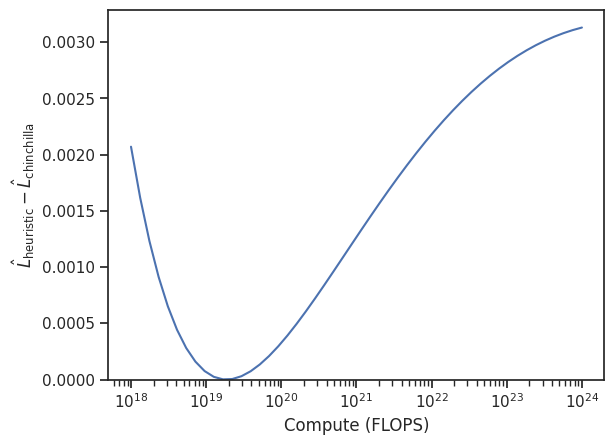

In [7]:
plt.semilogx(C, L_heuristic - L_chinchilla)
plt.xlabel("Compute (FLOPS)")
plt.ylabel(r"$\hat{L}_{\text{heuristic}} - \hat{L}_{\text{chinchilla}}$")
plt.ylim(0)
plt.show()

This is probably because the higher compute regime has flatter minima in terms of compute-allocation. 

[09:43:52] INFO     [235th] 1.00e+24 FLOPs => 1.60e+11 params * 1.04e+12 samples                        ]8;id=835022;file:///workspaces/chinchilla/chinchilla/core.py\core.py]8;;\:]8;id=88456;file:///workspaces/chinchilla/chinchilla/core.py#451\451]8;;\

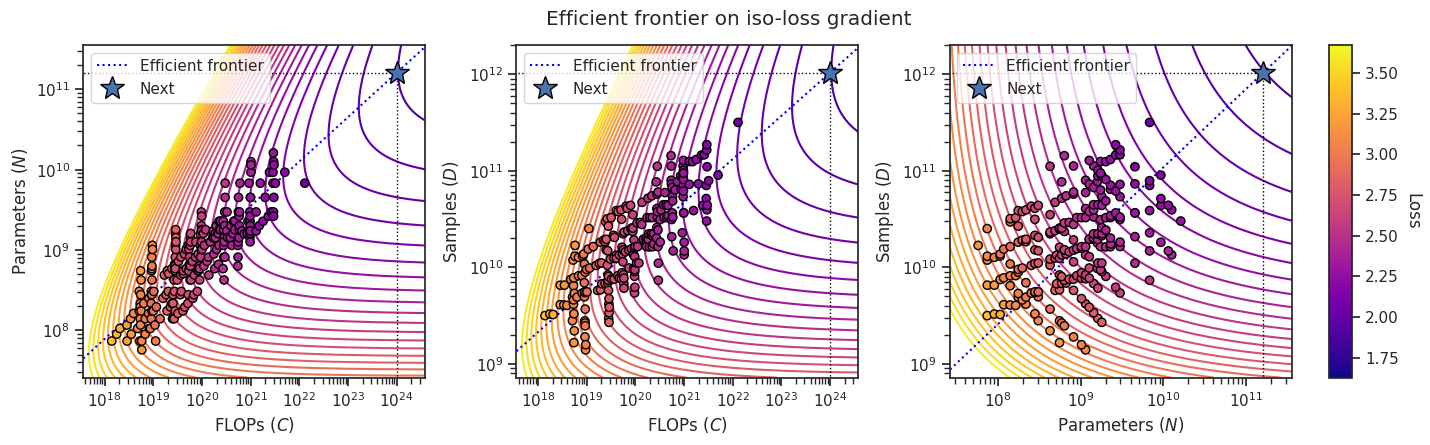

[09:43:55] INFO     Image saved to ./parametric_fit.png                                           ]8;id=178277;file:///workspaces/chinchilla/chinchilla/visualizer.py\visualizer.py]8;;\:]8;id=815467;file:///workspaces/chinchilla/chinchilla/visualizer.py#156\156]8;;\

In [8]:
_ = cc.scale(C=1e24)

As seen in the left & middle subplots, increasing/decreasing parameters or data woul'd result in a significantly divergence from the isoloss contour.